In [4]:
# 필요한 패키지 호출
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# 데이터 불러오기
data = pd.read_csv('C:/Users/user/Desktop/CJ/gangnam_series.csv')
#data = pd.read_csv('C:/Users/user/Desktop/CJ/gangseo_series.csv')
#data = pd.read_csv('C:/Users/user/Desktop/CJ/songpa_series.csv')

In [15]:
#train/test set 품목별 수동 분할 (현재 상품코드:4658408144)
train_df = data[0:83]
test_df = data[83:105]

print(train_df)
print(test_df)

print("Training Set Shape - ", train_df.shape)
print("Testing Set Shape - ", test_df.shape)

          date  ITEM_QTY          cd
0   2021-03-01         2  4802214590
1   2021-03-02        54  4802214590
2   2021-03-03        55  4802214590
3   2021-03-04         1  4802214590
4   2021-03-05        31  4802214590
..         ...       ...         ...
78  2021-05-27        40  4802214590
79  2021-05-28        20  4802214590
80  2021-05-29         3  4802214590
81  2021-05-30         6  4802214590
82  2021-05-31        10  4802214590

[83 rows x 3 columns]
           date  ITEM_QTY          cd
83   2021-06-01        10  4802214590
84   2021-06-02        35  4802214590
85   2021-06-03        10  4802214590
86   2021-06-04        24  4802214590
87   2021-06-05         9  4802214590
88   2021-06-06         2  4802214590
89   2021-06-07        65  4802214590
90   2021-06-09        13  4802214590
91   2021-06-11         4  4802214590
92   2021-06-14         9  4802214590
93   2021-06-15        25  4802214590
94   2021-06-16        47  4802214590
95   2021-06-17        10  4802214590
9

In [16]:
#SARIMA를 위한 파라미터 자동 분석 후 추천
from pmdarima import auto_arima
stepwise_model = auto_arima(train_df['ITEM_QTY'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=14,
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[14]             : AIC=inf, Time=1.56 sec
 ARIMA(0,1,0)(0,1,0)[14]             : AIC=665.227, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[14]             : AIC=662.756, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[14]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[14]             : AIC=665.384, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[14]             : AIC=664.351, Time=0.62 sec
 ARIMA(1,1,0)(1,1,1)[14]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,0)(0,1,1)[14]             : AIC=660.857, Time=0.27 sec
 ARIMA(1,1,0)(0,1,2)[14]             : AIC=inf, Time=2.20 sec
 ARIMA(1,1,0)(1,1,2)[14]             : AIC=inf, Time=3.32 sec
 ARIMA(0,1,0)(0,1,1)[14]             : AIC=661.686, Time=0.17 sec
 ARIMA(2,1,0)(0,1,1)[14]             : AIC=657.558, Time=0.44 sec
 ARIMA(2,1,0)(0,1,0)[14]             : AIC=662.409, Time=0.12 sec
 ARIMA(2,1,0)(1,1,1)[14]             : AIC=inf, Time=0.73 sec
 ARIMA(2,1,0)(0,1,2)[14]             : AIC=inf, Time=2.78

In [17]:
# MODEL FITTING(ARIMA)
# 테이블 : ARIMA (1, 0, 1) 모델을 피팅 한 후 생성 된 요약 테이블
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt

# 모델 정의
model = SARIMAX(train_df["ITEM_QTY"], order = (0, 1, 2))
# 모델 피팅
model_results = model.fit()

In [18]:
# MODEL FITTING(SARIMA)

# 모델정의 
seas_model = SARIMAX(data['ITEM_QTY'], order = (0, 1, 2), seasonal_order = (0, 1, 1, 14))
# 모델피팅
seas_model_results = seas_model.fit()

    lower ITEM_QTY  upper ITEM_QTY  Predictions
83      -19.760821       60.575660    22.244989
84      -18.900311       66.561332    26.954547
85      -18.900314       66.561334    22.726952
86      -18.900316       66.561337    20.702122
87      -18.900319       66.561339    26.211506


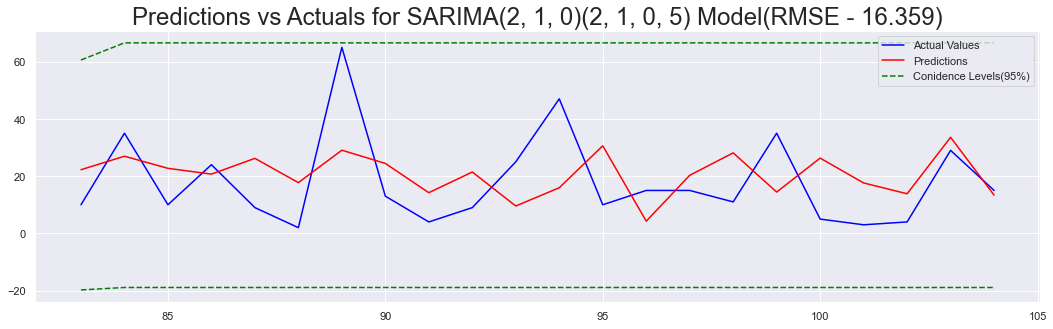

In [19]:
#신뢰구간
# 예측과 신뢰구간
forecasts = model_results.get_forecast(len(test_df.index)) # 예측 객체 생성
forecasts_df = forecasts.conf_int(alpha = 0.05)  # 신뢰구간 95%

# 실제의 예측값
from sklearn.metrics import mean_squared_error
forecasts_df["Predictions"] = seas_model_results.predict (start = test_df.index[0], end = test_df.index[-1])
print(forecasts_df.head()) #orecasts_df
# 예측값 RMSE
sarima_rmse = np.sqrt(mean_squared_error(y_true = test_df["ITEM_QTY"].values, y_pred = forecasts_df["Predictions"].values))
# 예측 신뢰구간 그래프
plt.rcParams["figure.figsize"] = 18, 5

# 테스트셋에서 ITEM_QTY 실제값
plt.plot(test_df["ITEM_QTY"], color = "blue", label = "Actual Values")




# 모델의 예측과 신뢰구간
plt.plot(forecasts_df["Predictions"], color = "red", label = "Predictions")
plt.plot(forecasts_df["upper ITEM_QTY"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(forecasts_df["lower ITEM_QTY"], color = "green", linestyle = "--")

#그래프 제목 작성 후 도출
plt.title(f"Predictions vs Actuals for SARIMA(2, 1, 0)(2, 1, 0, 5) Model(RMSE - {round(sarima_rmse, 3)})", size = 24)
plt.legend(loc = 'upper right')
plt.show()

In [8]:
forecasts_df1 = forecasts_df[['Predictions']] #Predictions 컬럼만 추출

In [9]:
train_df1 = train_df['ITEM_QTY'] #ITEM_QTY 컬럼만 추출

In [10]:
#모델을 train set에 맞게 조정해 미래 예측
result_seasonal=stepwise_model.fit(train_df1)
print(result_seasonal.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   83
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood                -368.579
Date:                           Tue, 09 Nov 2021   AIC                            747.158
Time:                                   09:35:56   BIC                            758.877
Sample:                                        0   HQIC                           751.846
                                            - 83                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4098      0.116     -3.533      0.000      -0.637      -0.182
ar.L2         -0.3666      0.092     -3.965

In [20]:
pred_seasonal = result_seasonal.predict(n_periods=7)#향후 7일치 수량 예측

import math
list=[]
sresult = 0

# 7일까지 판매갯수 합을 sresult에 저장
for i in range(0,len(pred_seasonal)):
    sresult = sresult + math.ceil(pred_seasonal[i])

# 7일까지 예측한 정수값을 올림 처리
for i in range(0,len(pred_seasonal)):
    list.append(math.ceil(pred_seasonal[i]))

list#미래 7일 예측 수량

[18, 16, 1, 0, 10, 15, 6]

In [21]:
sresult#미래 7일 예측 총수량

66